In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
dir = "Sequences/"
dir2 = "Hotel Sequence/"

In [2]:
#pip install kornia

In [21]:
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
from scipy import signal
import random
import scipy

ModuleNotFoundError: No module named 'google.colab'

In [4]:
corridor0 = cv2.imread(dir + '/corridor/bt_0.png')
corridor0 = (cv2.cvtColor(corridor0, cv2.COLOR_BGR2GRAY))
corridor1 = cv2.imread(dir + '/corridor/bt_1.png')
corridor1 = (cv2.cvtColor(corridor1, cv2.COLOR_BGR2GRAY)).astype(float) / 255
sphere0 = cv2.imread(dir + '/sphere/sphere_0.png')
sphere0 = (cv2.cvtColor(sphere0, cv2.COLOR_BGR2GRAY)).astype(float) / 255
sphere1 = cv2.imread(dir + '/sphere/sphere_1.png')
sphere1 = (cv2.cvtColor(sphere1, cv2.COLOR_BGR2GRAY)).astype(float) / 255
synth0 = cv2.imread(dir + '/synth/synth_0.png')
synth0 = (cv2.cvtColor(synth0, cv2.COLOR_BGR2GRAY)).astype(float) / 255
synth1 = cv2.imread(dir + '/synth/synth_1.png')
synth1 = (cv2.cvtColor(synth1, cv2.COLOR_BGR2GRAY)).astype(float) / 255

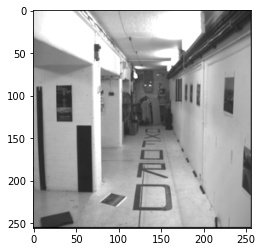

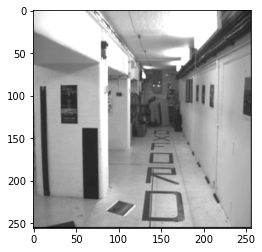

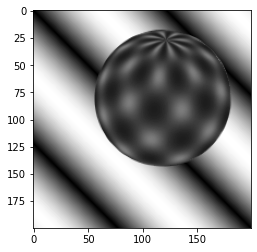

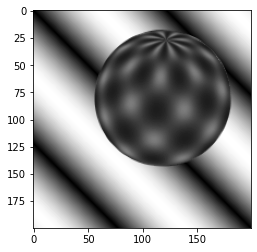

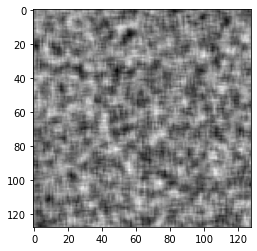

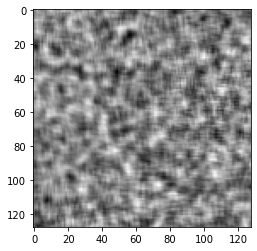

In [5]:
plt.figure()
plt.imshow(corridor0, cmap = 'gray')
plt.figure()
plt.imshow(corridor1, cmap = 'gray')
plt.figure()
plt.imshow(sphere0, cmap = 'gray')
plt.figure()
plt.imshow(sphere1, cmap = 'gray')
plt.figure()
plt.imshow(synth0, cmap = 'gray')
plt.figure()
plt.imshow(synth1, cmap = 'gray')

In [6]:
def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

In [7]:
def myFlow(img1, img2, window_size, threshold):

    w = window_size/2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    w = int(w)
    kernel_x = np.array([-1,8,0,-8,1])
    kernel_x = np.reshape(kernel_x, (1,5))
    kernel_x = kernel_x/12
    fx = signal.convolve2d(img1,kernel_x)

    

    kernel_y = np.array([-1,8,0,-8,1])
    kernel_y = np.reshape(kernel_y, (5,1))
    kernel_y = kernel_y/12
    fy = signal.convolve2d(img1,kernel_y)


    dt0 = gaussian_filter(img1, sigma=1)
    dt1 = gaussian_filter(img2, sigma=1)
    ft = dt0 - dt1
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    binary_map = np.zeros(img1.shape)

    count = 0

    for i in range(w, img1.shape[0]-w):
        for j in range(w, img1.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1))
            A = np.vstack((Ix, Iy)).T # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= threshold:
              disp = np.matmul(np.linalg.pinv(A), b) # get velocity here
              #print(disp)
              u[i,j]=disp[0]
              v[i,j]=disp[1]
              binary_map[i,j] = 1
            else:
              u[i,j]=0
              v[i,j]=0
              binary_map[i,j] = 0
            
            #print(u[i,j], v[i,j], binary_map[i,j])

 
    return (u,v, binary_map)

In [8]:
def visualize(img1,img2):
  u,v,binary_map= myFlow(img1,img2, 11,0.001)
  image = np.dstack([u, v])
  output = flowToColor(image)
  plt.figure()
  plt.imshow(output)
  plt.figure()
  plt.imshow(binary_map)


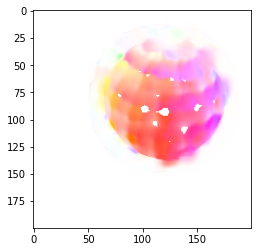

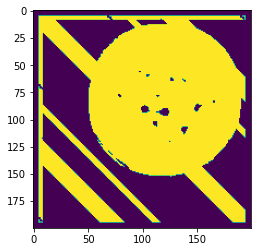

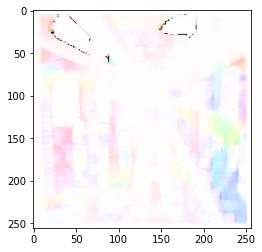

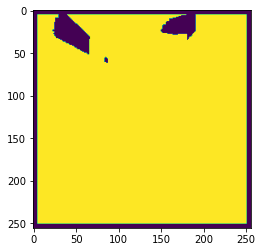

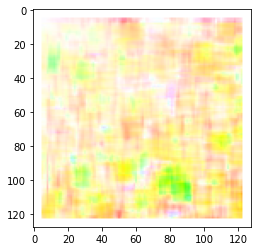

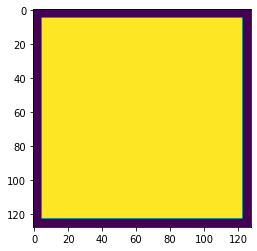

In [9]:
visualize(sphere0,sphere1)
visualize(corridor0,corridor1)
visualize(synth0,synth1)

In [10]:
def myWarp(img, u, v):

    height, width = img.shape
    
    x = np.arange(1, img.shape[0]+1)
    y = np.arange(1, img.shape[1]+1)
    
    x_warped = x - u
    y_warped = y - v

    cubic = scipy.interpolate.interp2d(x, y, img, kind='cubic')
    linear = scipy.interpolate.interp2d(x, y, img, kind='linear')
    
    warped_bicubic = cubic(x, y)
    warped_bilinear = linear(x, y)
    
    plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(np.abs(img-warped_bicubic))
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(np.abs(img-warped_bilinear))
    ax3 = plt.subplot(1, 3, 3)
    for i in range(10):
        ax3.imshow(img)
        ax3.imshow(warped_bilinear)
        plt.draw()
    
    return warped_bicubic, warped_bilinear

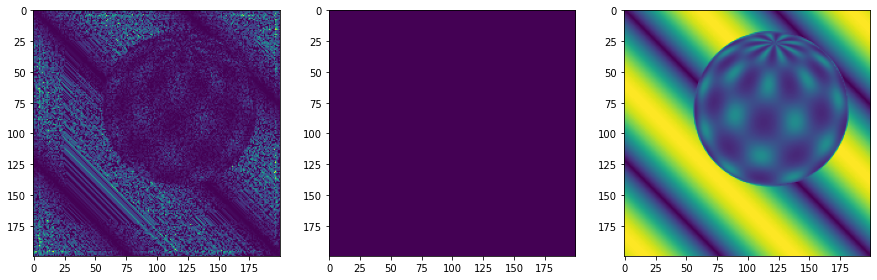

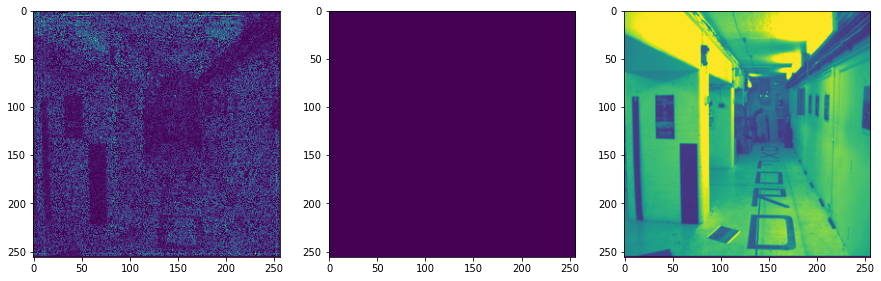

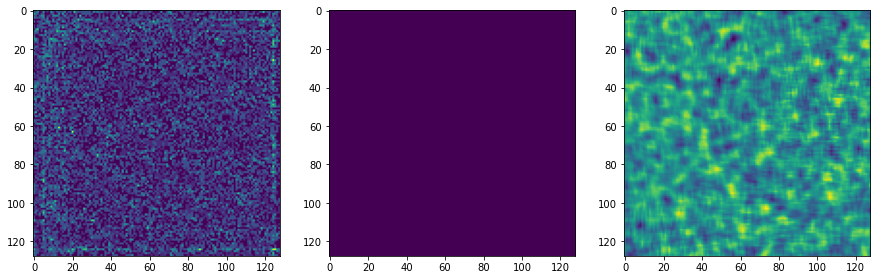

In [11]:
u,v,binary_map= myFlow(sphere0,sphere1, 11,0.001)
a,b = myWarp(sphere1,u,v)
u,v,binary_map= myFlow(corridor0,corridor1, 11,0.001)
a,b = myWarp(corridor1,u,v)
u,v,binary_map= myFlow(synth0,synth1, 11,0.001)
a,b = myWarp(synth1,u,v)

In [36]:
def detectKeyPoint(img):

  feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.1, 
                       minDistance = 5,  
                       blockSize = 7)     
  points = cv2.goodFeaturesToTrack(img, mask = None, **feature_params)

  # convert to kx2 format, where k is the number of feature points
  corners = np.zeros((points.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = points[i][0]

  # draw a small circle at each detected point and display the result
  newImg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  keyPoints = np.intp(np.round(corners)) # convert to integers used for indexing 
  

  radius = 3
  color = (0, 0, 255)

  for i in keyPoints:
    x, y = i.ravel()      # returns a contiguous flattened array
    cv2.circle(newImg, (x, y), radius, color)

  plt.imshow(newImg)
  return keyPoints

In [37]:
def trackPoints(points, images):

  # Holds nextPoints
  pointList = []

  for k in range(len(images)-1):
    
    pointsCopy = np.copy(points).astype(float)
    img1 = images[k].astype(np.float32)
    img2 = images[k+1].astype(np.float32)

    img = gaussian_filter(img1, sigma=1)
    Iy, Ix =  np.gradient(img)

    #KLT 
    for i in range(len(points)):
      patch_x = cv2.getRectSubPix(Ix, (15,15), (int(points[i,0]), int(points[i,1])))
      patch_y = cv2.getRectSubPix(Iy, (15,15), (int(points[i,0]), int(points[i,1])))
      A = np.array([[np.sum(patch_x * patch_x), np.sum(patch_x * patch_y)], [np.sum(patch_x * patch_y), np.sum(patch_y * patch_y)]])

      for j in range(25):
        patch_t = cv2.getRectSubPix(img2, (15,15), (int(pointsCopy[i,0]), int(pointsCopy[i,1]))) - cv2.getRectSubPix(img, (15, 15), (int(points[i,0]), int(points[i,1])))
        B = -1* np.array([[np.sum(patch_x*patch_t)],[np.sum(patch_y*patch_t)]])
        disp = np.matmul(np.linalg.pinv(A), B)

        u = disp[0]
        v = disp[1]

        #print(u, v)

        if pointsCopy[i,0] + u >= len(img1) or pointsCopy[i,0] + u < 0 or pointsCopy[i,1] + v >= len(img1[0]) or pointsCopy[i,1] + v < 0:
          continue
        else:
          pointsCopy[i] = [pointsCopy[i,0] + u, pointsCopy[i,1] + v] 

    points = pointsCopy

    for point in pointsCopy:
      pointList.append(point)
 
  return pointList


C:\Users\Jimmy\AppData\Local\Temp\ipykernel_8416\610127726.py:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  pointsCopy[i] = [pointsCopy[i,0] + u, pointsCopy[i,1] + v]


[array([409.93914795, 347.69216919]), array([258.0869751 , 345.62783813]), array([147.00691223, 194.99928284]), array([375.38793945, 253.28024292]), array([362.35888672, 327.70779419]), array([313.40289307, 424.32015991]), array([431.93862915, 429.23999023]), array([264.53668213, 282.32064819]), array([170.53794861, 127.59664154]), array([283.59979248, 452.59921265]), array([186.32252502, 259.5796814 ]), array([443.26800537, 378.62521362]), array([176.48130798, 335.91571045]), array([192.25328064, 263.45346069]), array([253.28981018, 340.35125732]), array([320.54858398, 240.19841003]), array([255.5597229 , 460.20889282]), array([400.57495117, 342.68963623]), array([226.94827271, 267.47921753]), array([163.66111755, 110.88663483]), array([409.75848389, 348.73175049]), array([257.88253784, 345.43386841]), array([148.06933594, 194.13768005]), array([376.51168823, 254.46403503]), array([362.34866333, 328.36471558]), array([312.20330811, 424.56671143]), array([430.26928711, 431.62142944]), 

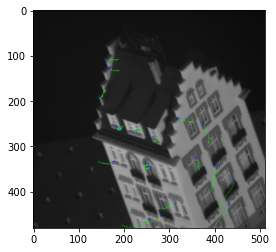

In [39]:
def KLT():
  images = []#Holds all hotel images
  for i in range(51):
      temp = cv2.imread(dir2 + "hotel.seq" + f'{i}' + ".png", cv2.COLOR_BGR2GRAY)
      images.append(temp)

  firstFrame = images[0]
  points =  detectKeyPoint(firstFrame)

  randomizedPoints = random.sample(points.tolist(),20) #randomly picks 20 points to track
  randomizedPoints = np.asarray(randomizedPoints)

  img0 = cv2.cvtColor(images[0], cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(randomizedPoints))  
  radius = 3
  color = (0, 0, 255)
  for i in corners:
    x, y = i.ravel()
    cv2.circle(img0, (x, y), radius, color)

  trackedPoints = trackPoints(randomizedPoints, images)

  color = (0, 255, 0)

  print(trackedPoints)

  for pt in trackedPoints:
    pathImg = cv2.circle(img0, (round(pt[0]),round(pt[1])), radius=0, color=color, thickness=1)

  plt.imshow(pathImg)

KLT()